# CANN'Y Edge Detection

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [31]:
def MaskGeneration(T, sigma):
    shalf = np.round(np.sqrt(-np.log(T) * 2 * (sigma ** 2)))
    total_mask_size = 2*shalf + 1
    
    y, x = np.meshgrid(range(-int(shalf), int(shalf) + 1), range(-int(shalf), int(shalf) + 1))
    return x, y

In [32]:
def Gaussian(x,y, sigma):
    return (np.exp(-((x ** 2) + (y ** 2)) / (2 * (sigma ** 2))))

def guassian_X(x,y, sigma):
    return -((x * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))) / sigma ** 2)

def guassian_Y(x,y, sigma):
    return -((y * np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))) / sigma ** 2)

In [33]:
def smooth(img, kernel=None):
    if kernel is None:
        mask = np.array([[1,1,1],[1,1,1],[1,1,1]])
    else:
        mask = kernel
    i, j = mask.shape
    output = np.zeros((img.shape[0], img.shape[1]))
    row, col = img.shape
    mrow, mcol = mask.shape
    padding = np.zeros((row + mrow,col + mcol), dtype=img.dtype)
    add = np.int((mrow)/2)
    padding[add: add + row, add: add + col] = img         
    for x in range(img.shape[0]):    
        for y in range(img.shape[1]):
            output[x, y] = (mask * padding[x:x+i, y:y+j]).sum() / mask.sum()  
    return output


In [34]:
def scaleup_Gx(fx, fy):
    gx = (guassian_X(fx, fy, sigma)) * 255
    return np.around(gx)

def scaleup_Gy(fx, fy):    
    gy = (guassian_Y(fx, fy, sigma)) * 255
    return np.around(gy)

In [35]:
def ApplyMask(image, kernel):
    i, j = kernel.shape
    kernel = np.flipud(np.fliplr(kernel))    
    output = np.zeros_like(image) 
    row, col = image.shape
    mrow, mcol = kernel.shape
    padding = np.zeros((row + mrow,col + mcol), dtype=image.dtype)
    add = np.int((mrow)/2)
    padding[add: add + row, add: add + col] = image          
    for x in range(image.shape[0]):    
        for y in range(image.shape[1]):
            output[x, y] = (kernel * padding[x:x+i, y:y+j]).sum()        
    return output

In [60]:
def Gradient_Magnitude(fx, fy):
    magnitude = np.zeros((fx.shape[0], fx.shape[1]))
    magnitude = np.sqrt((fx ** 2) + (fy ** 2))
    magnitude = magnitude * 100 / magnitude.max()
    return np.around(magnitude)

def Gradient_Direction(fx, fy):
    dir = np.zeros((fx.shape[0], fx.shape[1]))
    dir = np.rad2deg(np.arctan2(fy, fx)) + 180
    return dir

In [37]:
def Quantize_dir(dir):
    quantized = np.zeros((dir.shape[0], dir.shape[1]))
    for i in range(dir.shape[0]):
        for j in range(dir.shape[1]):
            if 0 <= dir[i, j] <= 22.5 or 157.5 <= dir[i, j] <= 202.5 or 337.5 < dir[i, j] < 360:
                quantized[i, j] = 0
            elif 22.5 <= dir[i, j] <= 67.5 or 202.5 <= dir[i, j] <= 247.5:
                quantized[i, j] = 1
            elif 67.5 <= dir[i, j] <= 122.5 or 247.5 <= dir[i, j] <= 292.5:
                quantized[i, j] = 2
            elif 112.5 <= dir[i, j] <= 157.5 or 292.5 <= dir[i, j] <= 337.5:
                quantized[i, j] = 3
    return quantized
    
def Non_Max_Suppression(q, dir, m):
    M = np.zeros(q.shape)
    a, b = np.shape(q)
    for i in range(a-1):
        for j in range(b-1):
            if q[i,j] == 0:
                if  dir[i,j-1]< dir[i,j] or dir[i,j] > dir[i,j+1]:
                    M[i,j] = m[i,j]
                else:
                    M[i,j] = 0
            if q[i,j]==1:
                if  dir[i-1,j+1]<= dir[i,j] or dir[i,j] >= dir[i+1,j-1]:
                    M[i,j] = m[i,j]
                else:
                    M[i,j] = 0       
            if q[i,j] == 2:
                if  dir[i-1,j]<= dir[i,j] or dir[i,j] >= dir[i+1,j]:
                    M[i,j] = m[i,j]
                else:
                    M[i,j] = 0
            if q[i,j] == 3:
                if  dir[i-1,j-1]<= dir[i,j] or dir[i,j] >= dir[i+1,j+1]:
                    M[i,j] = m[i,j]
                else:
                    M[i,j] = 0
    return M

def colorized(q, mag):
    color = np.zeros((mag.shape[0], mag.shape[1], 3), np.uint8)
    a, b = np.shape(mag)
    for i in range(a-1):
        for j in range(b-1):
            if q[i,j] == 0:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                else:
                    color[i,j,0] = 0
            if q[i,j] == 1:
                if mag[i,j] != 0:
                    color[i,j,1] = 255
                else:
                    color[i,j,1] = 0
            if q[i,j] == 2:
                if mag[i,j] != 0:
                    color[i,j,2] = 255
                else:
                    color[i,j,2] = 0
            if q[i,j] == 3:
                if mag[i,j] != 0:
                    color[i,j,0] = 255
                    color[i,j,1] = 255
                    
                else:
                    color[i,j,0] = 0
                    color[i,j,1] = 0
    return color

In [38]:
def _double_thresholding(g_suppressed, low_threshold, high_threshold):
    g_thresholded = np.zeros(g_suppressed.shape)
    for i in range(0, g_suppressed.shape[0]):		# loop over pixels
        for j in range(0, g_suppressed.shape[1]):
            if g_suppressed[i,j] < low_threshold:	# lower than low threshold
                g_thresholded[i,j] = 0
            elif g_suppressed[i,j] >= low_threshold and g_suppressed[i,j] < high_threshold: 	# between thresholds
                g_thresholded[i,j] = 128
            else:					        # higher than high threshold
                g_thresholded[i,j] = 255
    return g_thresholded

def _hysteresis(g_thresholded):
    g_strong = np.zeros(g_thresholded.shape)
    for i in range(0, g_thresholded.shape[0]):		# loop over pixels
        for j in range(0, g_thresholded.shape[1]):
            val = g_thresholded[i,j]
            if val == 128:			# check if weak edge connected to strong
                if g_thresholded[i-1,j] == 255 or g_thresholded[i+1,j] == 255 or g_thresholded[i-1,j-1] == 255 or g_thresholded[i+1,j-1] == 255 or g_thresholded[i-1,j+1] == 255 or g_thresholded[i+1,j+1] == 255 or g_thresholded[i,j-1] == 255 or g_thresholded[i,j+1] == 255:
                    g_strong[i,j] = 255		# replace weak edge as strong
            elif val == 255:
                g_strong[i,j] = 255		# strong edge remains as strong edge
    return g_strong

# Step 1 Specify sigma and T value Also calculate Gradient masks
Here you will give the values of sigma and T(0-1). This will create the size of filter automatically. We generate gradient masks in x and y directions i.e. Gx and Gy

In [325]:
sigma = 0.5
T = 0.3
x, y = MaskGeneration(T, sigma)
gauss = Gaussian(x, y, sigma)

In [326]:
gx = -scaleup_Gx(x, y)
gy = -scaleup_Gy(x, y)

# Step 2 Reading and converting image into grayscale
Here we convert the image into grayscale image for easy processing and finding edges

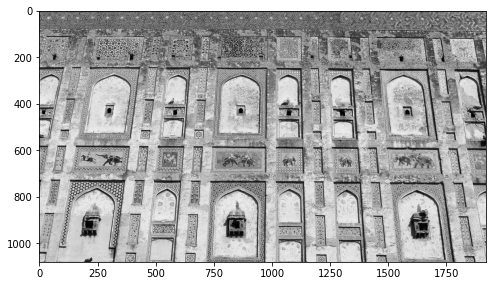

In [327]:
image = cv2.imread('/content/wallLahoreFortBBC.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (8,8))
plt.imshow(gray, cmap='gray')
plt.show()

## Smoothing
Here we smooth the image to reduce the intensity in the pixels

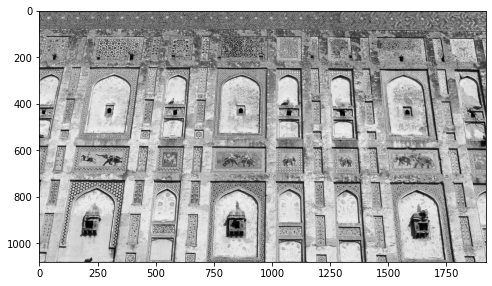

In [328]:
smooth_img = smooth(gray, gauss)
plt.figure(figsize = (8,8))
plt.imshow(smooth_img, cmap='gray')

# Step 3 Applying the Gradient masks
In this step we apply the gradient x and y masks on the image.

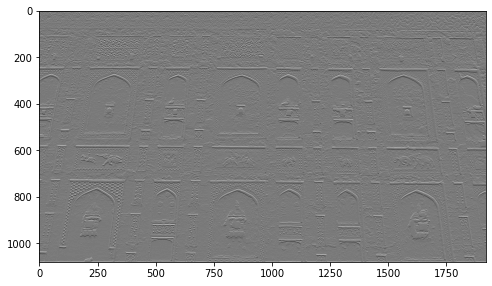

In [329]:
fx = ApplyMask(smooth_img, gx)
plt.figure(figsize = (8,8))
plt.imshow(fx, cmap='gray')

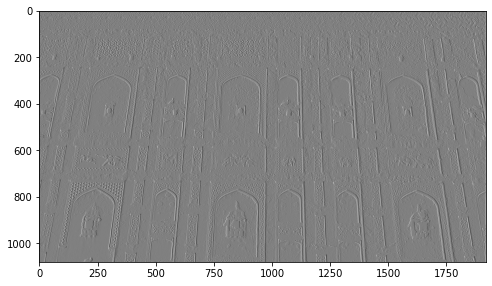

In [330]:
fy = ApplyMask(smooth_img, gy)
plt.figure(figsize = (8,8))
plt.imshow(fy, cmap='gray')

# Step 4 Gradient magnitude
In this step we calculate the gradient magnitude at every pixel location

max 100.0
min 0.0


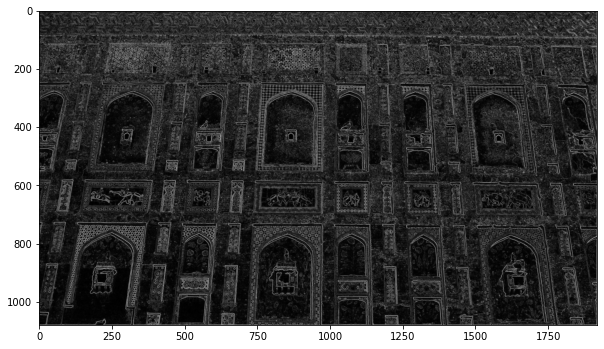

In [331]:
M = Gradient_Magnitude(fx, fy)
#M = M.astype(int)
plt.figure(figsize = (10,10))
plt.imshow(M, cmap='gray')
print('max', M.max())
print('min', M.min())

# STEP 5 Gradient Direction
In this step we find direction of gradient at each pixel of the image.

max 360.0
min 0.0


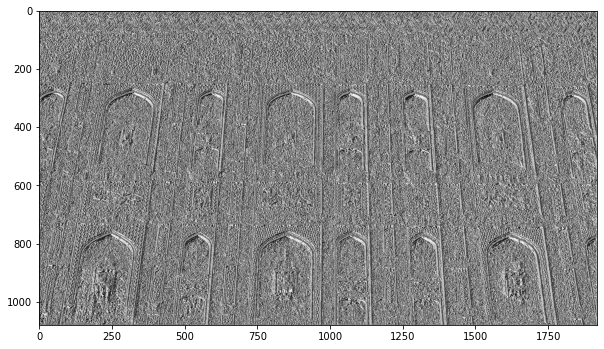

In [332]:
direction = Gradient_Direction(fx, fy)
plt.figure(figsize = (10,10))
plt.imshow(direction, cmap='gray')
print('max', direction.max())
print('min', direction.min())

# Step 6 Quantization of angles and Non-Max Suppression
In this step we quantize our angles into 4 groups 0, 1, 2, 3. Then we apply non-maximum suppression on it to make the edges thin

max 94.0
min 0.0


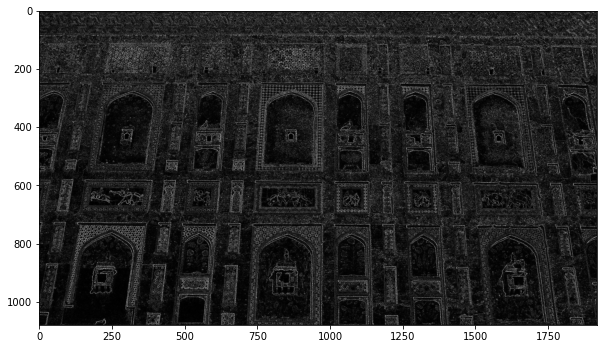

In [333]:
quantized = Quantize_dir(direction)
nms = Non_Max_Suppression(quantized, direction, M)
plt.figure(figsize = (10,10))
plt.imshow(nms, cmap='gray')
print('max', nms.max())
print('min', nms.min())

### Colorized Image for visualiztion of angles

True

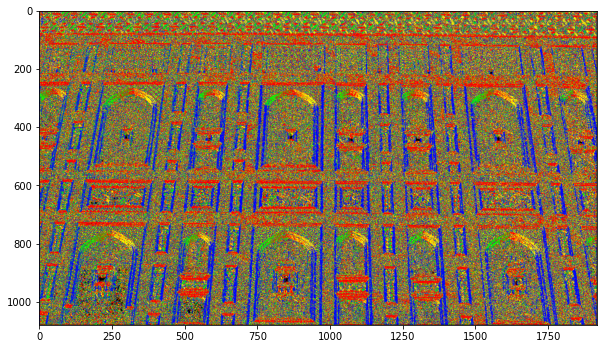

In [334]:
colored = colorized(quantized, M)
plt.figure(figsize = (10,10))
plt.imshow(colored)
cv2.imwrite('color.jpg',colored)

# Step 7 Double Threshold and Hysteresis
In this step we apply double threshold Tl and Th to our non-maximum suppressed images. After that we apply Hysteresis algorithm to get resultant edges of the image.

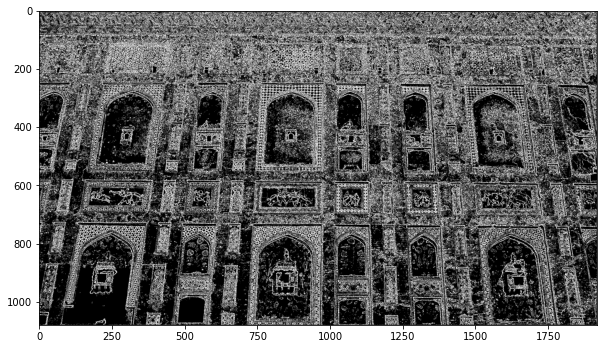

In [335]:
threshold = _double_thresholding(nms, 10, 20)
cv2.imwrite('double_thresholded.jpg', threshold )
plt.figure(figsize = (10,10))
plt.imshow(threshold, cmap='gray')

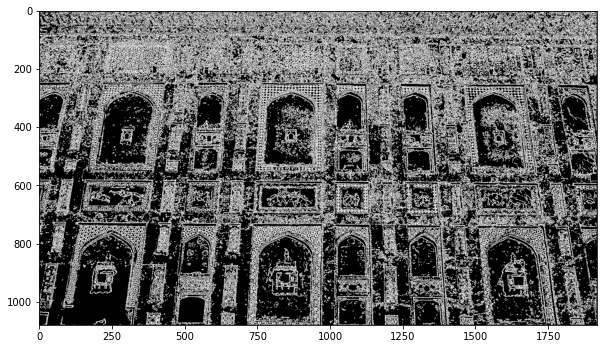

In [336]:
hys = _hysteresis(threshold)
cv2.imwrite('Result.jpg', hys)
plt.figure(figsize = (10,10))
plt.imshow(hys, cmap='gray')

# Guassian Filter Derivative Plot

Gaussian Filter


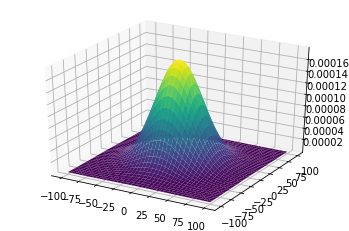

In [51]:
# Utility function to plot 3D surface
def surf(X, Y, Z): 
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    
sigma = 30
from mpl_toolkits.mplot3d import Axes3D

[X, Y] = np.meshgrid(np.arange(-100, 101), np.arange(-100, 101))

Z = 1/((2.0 * np.pi) * sigma**2) * np.exp(-(X**2+Y**2)/(2.0*sigma**2))

dx= -X/((2.0 * np.pi) * sigma**4) * np.exp(-(X**2+Y**2)/(2.0*sigma**2))

dx2 = ((X**2-sigma**2) * np.exp(-(X**2+Y**2)/(2.0*sigma**2))) /((2.0 * np.pi) * sigma**6)

dy= -Y/((2.0 * np.pi) * sigma**4) * np.exp(-(X**2+Y**2)/(2.0*sigma**2))

dy2 = ((Y**2-sigma**2) * np.exp(-(X**2+Y**2)/(2.0*sigma**2))) /((2.0 * np.pi) * sigma**6)


print('Gaussian Filter')
surf(X, Y, Z)

First order derivative w.r.t "X"


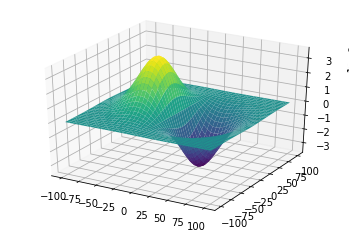

In [52]:
print('First order derivative w.r.t "X"')
surf(X, Y, dx)

First order derivative w.r.t "Y"


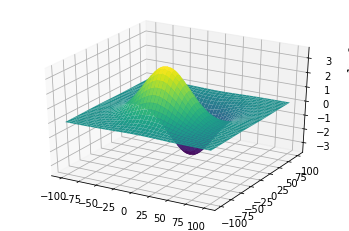

In [53]:
print('First order derivative w.r.t "Y"')
surf(X, Y, dy)

First order derivative


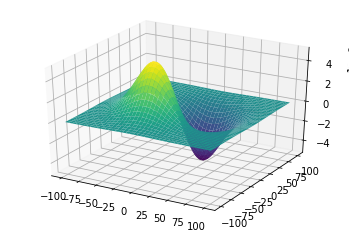

In [54]:
print('First order derivative')
surf(X, Y, dx+dy)

2nd order derivative w.r.t "X"


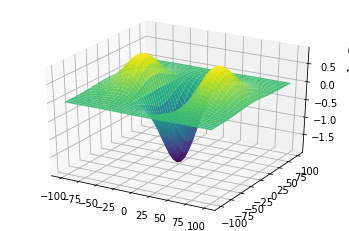

In [55]:
print('2nd order derivative w.r.t "X"')
surf(X, Y, dx2)

2nd order derivative w.r.t "Y"


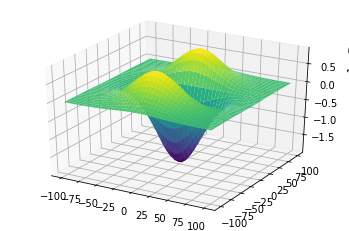

In [56]:
print('2nd order derivative w.r.t "Y"')
surf (X,Y, dy2)

2nd order derivative


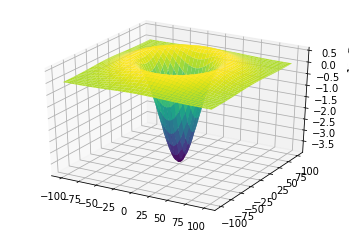

In [57]:
print('2nd order derivative')
surf(X, Y, dx2+dy2)